## 4차 과제 - Hyperparameter Tuning을 해보자
- 주제: 하이퍼파라미터 튜닝 기법 학습
- 데이터: The History of Baseball(Pitching Data) https://www.kaggle.com/datasets/seanlahman/the-history-of-baseball?select=pitching.csv
- 사용 라이브러리: pandas, numpy, matplotlib, sklearn, imblearn, bayes_opt

### 1. EDA, 전처리

1.1 분석을 위해 사용될 라이브러리들을 import 하세요.

numpy, pandas, matplotlib, SMOTE, train_test_split, RandomForestClassifier, RandomizedSearchCV, GridSearchCV, BayesianOptimization, accuracy_score

In [2]:
!pip install bayesian-optimization

In [3]:
from multiprocessing import cpu_count

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from bayes_opt import BayesianOptimization

1.2 데이터를 불러오고 info()를 통해 데이터를 살펴보세요.

In [5]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cheyoung211","key":"00fb5c6d79c543e190360503792d8810"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d seanlahman/the-history-of-baseball

100% 20.5M/20.5M [00:01<00:00, 29.0MB/s]
100% 20.5M/20.5M [00:01<00:00, 21.0MB/s]


In [8]:
!unzip -qq '/content/the-history-of-baseball.zip'

In [9]:
data = pd.read_csv('/content/pitching.csv')

In [10]:
data

,player_id,year,stint,team_id,league_id,w,l,g,gs,cg,...,ibb,wp,hbp,bk,bfp,gf,r,sh,sf,g_idp
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,NaN,NaN,NaN,0,NaN,NaN,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,NaN,NaN,NaN,0,NaN,NaN,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,NaN,NaN,NaN,0,NaN,NaN,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,NaN,NaN,NaN,0,NaN,NaN,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,NaN,NaN,NaN,0,NaN,NaN,21,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44134,youngch03,2015,1,KCA,AL,11,6,34,18,0,...,0.0,5.0,0.0,0,500.0,3.0,44,4.0,2.0,NaN
44135,zieglbr01,2015,1,ARI,NL,0,3,66,0,0,...,3.0,2.0,1.0,0,263.0,46.0,17,1.0,0.0,NaN
44136,zimmejo02,2015,1,WAS,NL,13,10,33,33,0,...,3.0,2.0,8.0,1,831.0,0.0,89,8.0,2.0,NaN
44137,zitoba01,2015,1,OAK,AL,0,0,3,2,0,...,0.0,0.0,0.0,0,37.0,1.0,8,0.0,0.0,NaN


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44139 entries, 0 to 44138
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player_id  44139 non-null  object 
 1   year       44139 non-null  int64  
 2   stint      44139 non-null  int64  
 3   team_id    44139 non-null  object 
 4   league_id  44008 non-null  object 
 5   w          44139 non-null  int64  
 6   l          44139 non-null  int64  
 7   g          44139 non-null  int64  
 8   gs         44139 non-null  int64  
 9   cg         44139 non-null  int64  
 10  sho        44139 non-null  int64  
 11  sv         44139 non-null  int64  
 12  ipouts     44138 non-null  float64
 13  h          44139 non-null  int64  
 14  er         44139 non-null  int64  
 15  hr         44139 non-null  int64  
 16  bb         44139 non-null  int64  
 17  so         44139 non-null  int64  
 18  baopp      42614 non-null  float64
 19  era        44049 non-null  float64
 20  ibb   

<Axes: >

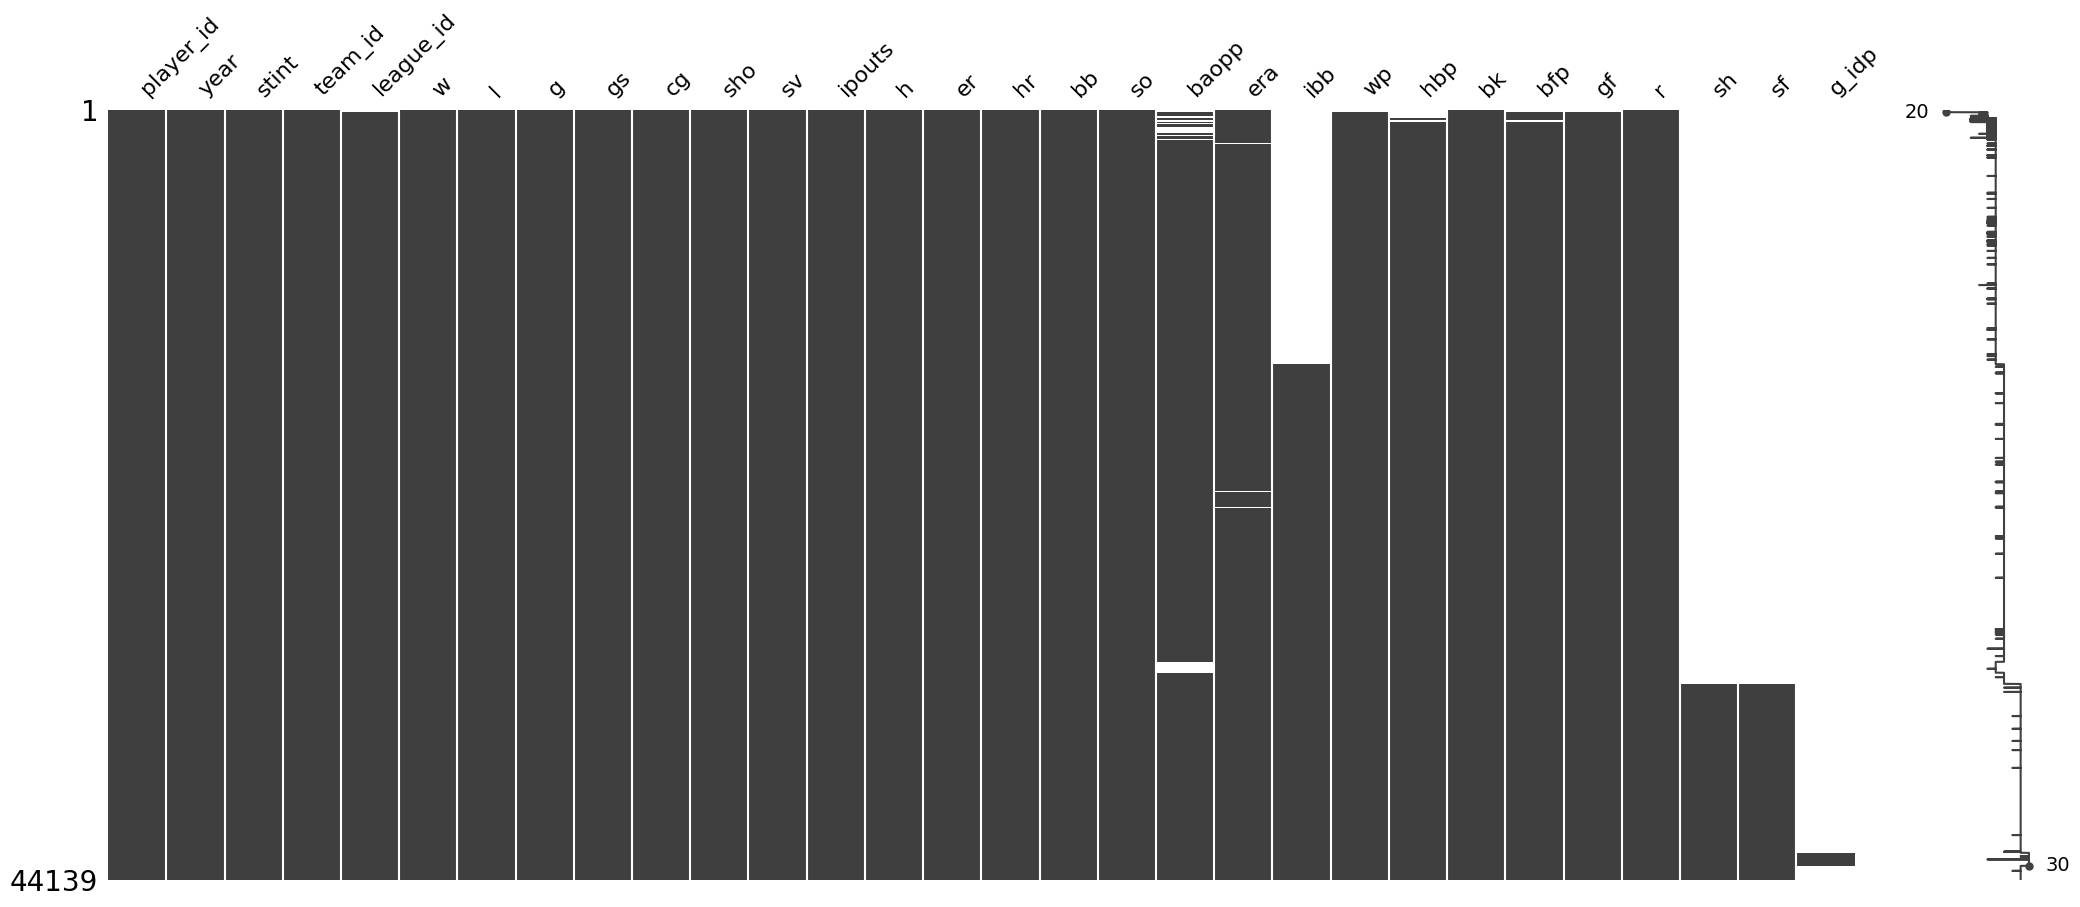

In [12]:
import missingno as msno
msno.matrix(data)

1.3 null 값이 있는 컬럼은 모두 삭제하겠습니다(원래는 다른 처리를 해야 하지만 컬럼 수는 충분하니까..ㅎㅎ 야구 잘 몰라서 그런 거 아닙니다.).

In [13]:
nulldrop = data.dropna(axis = 1)

In [14]:
nulldrop

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,bechtge01,1871,1,PH1,1,2,3,3,2,0,0,43,23,0,11,1,0,42
1,brainas01,1871,1,WS3,12,15,30,30,30,0,0,361,132,4,37,13,0,292
2,fergubo01,1871,1,NY2,0,0,1,0,0,0,0,8,3,0,0,0,0,9
3,fishech01,1871,1,RC1,4,16,24,24,22,1,0,295,103,3,31,15,0,257
4,fleetfr01,1871,1,NY2,0,1,1,1,1,0,0,20,10,0,3,0,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44134,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
44135,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
44136,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
44137,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


<Axes: >

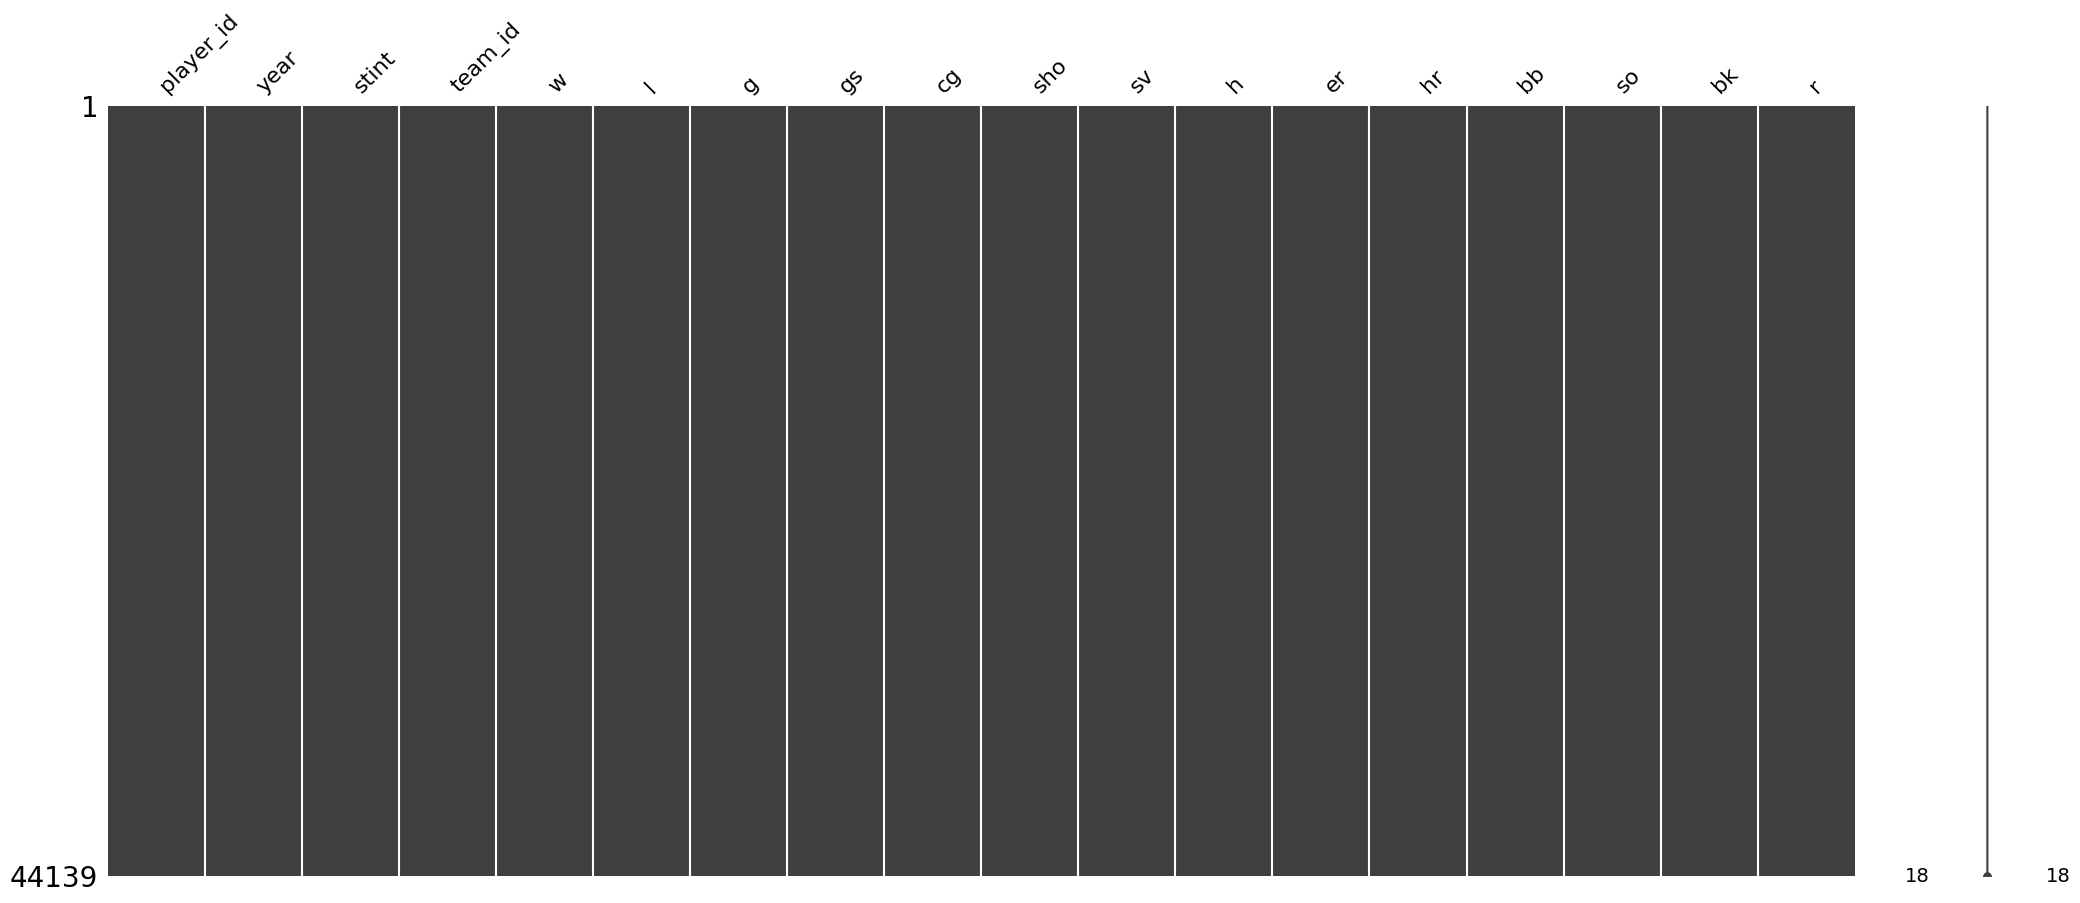

In [15]:
msno.matrix(nulldrop)

1.4 연도 별로 몇개의 데이터가 있는 지 확인 후 데이터가 얼마 없는 과거 데이터는 삭제하겠습니다. 이를 위해 연도 별 데이터 수를 계산하고 line plot으로 그리세요.

In [16]:
year_counts = nulldrop['year'].value_counts().sort_index()

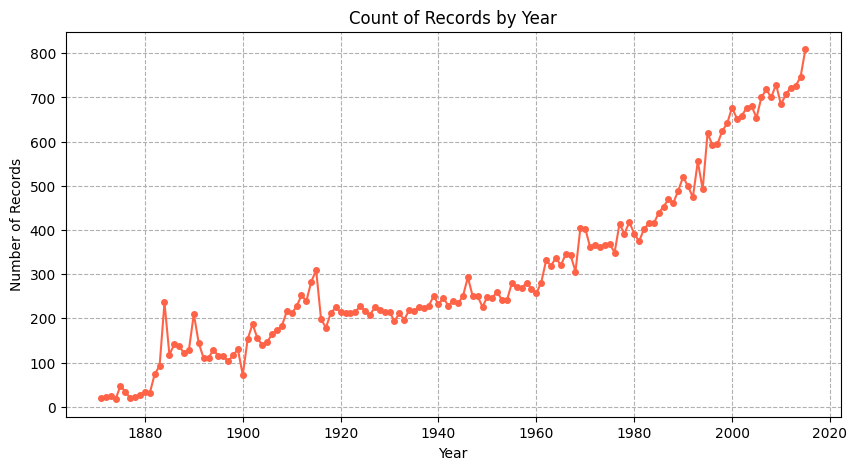

In [17]:
plt.figure(figsize = (10,5))
plt.plot(year_counts.index, year_counts.values, marker='o', markersize = 4, linestyle='-', color = 'tomato')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.title('Count of Records by Year')
plt.grid(True, linestyle = '--')
plt.show()

1.5 보다 최신 분석을 위해 1980년 이후의 데이터만 남기고 몇개의 데이터가 남았는지 확인하세요.

In [18]:
newdata = nulldrop[nulldrop['year'] >= 1980]

In [19]:
newdata

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
22982,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
22983,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
22984,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
22985,allarbr01,1980,1,TEX,0,1,5,2,0,0,0,13,9,0,10,10,0,13
22986,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44134,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
44135,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
44136,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
44137,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


1.6 reset_index()를 통해 재배열하세요.

In [20]:
newdata2 = newdata.reset_index()
newdata2.drop(['index'], axis = 1)
newdata2

,index,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,22982,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
1,22983,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
2,22984,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
3,22985,allarbr01,1980,1,TEX,0,1,5,2,0,0,0,13,9,0,10,10,0,13
4,22986,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21152,44134,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
21153,44135,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
21154,44136,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
21155,44137,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


1.7 투수의 승리 수를 예측해보겠습니다. w 컬럼의 value를 확인해보세요.

In [21]:
w_column = newdata2['w']
print(w_column.unique())

[ 8 12 14  0  7  3  6  4  1  9 19  2  5 10 15 13 11 24 16 17 18 22 20 25
 23 21 27]


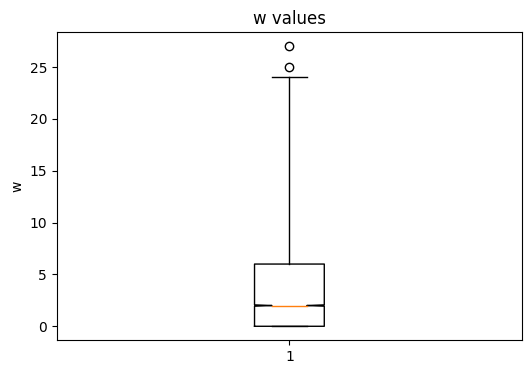

In [22]:
plt.figure(figsize = (6,4))
plt.boxplot(w_column, whis = 3, notch = True)
plt.title('w values')
plt.ylabel('w')
plt.show()

1.8 0승 투수(출전하지 않은 경우도 존재)가 많으므로 승리 수가 0인 데이터는 삭제하겠습니다.

In [23]:
won = newdata2[newdata2['w'] != 0]
won = won.drop(['index'], axis = 1)
won

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
4,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
6,andujjo01,1980,1,HOU,3,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,wrighmi01,2015,1,BAL,3,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,wrighst01,2015,1,BOS,5,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,yateski01,2015,1,TBA,1,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44


1.9 Regression이 아닌 Classification으로 분석해보겠습니다. 이를 위해 10을 기준으로 w를 10승 이상이면 1, 10승 미만이면 0인 Binary 형태로 변환하세요.

In [24]:
won['w'] = won['w'].apply(lambda x : 1 if x >= 10 else 0)

In [25]:
won

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,0,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,1,11,35,35,7,1,0,227,108,20,74,114,0,120
4,allenne01,1980,1,NYN,0,10,59,0,0,0,22,87,40,7,40,79,1,43
6,andujjo01,1980,1,HOU,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,wrighmi01,2015,1,BAL,0,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,wrighst01,2015,1,BOS,0,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,yateski01,2015,1,TBA,0,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,youngch03,2015,1,KCA,1,6,34,18,0,0,0,91,42,16,43,83,0,44


In [26]:
won['w'].unique()

array([0, 1])

1.10 value_counts()를 통해 잘 나눠졌는지 확인해보세요.

In [27]:
won['w'].value_counts()

w
0    12589
1     2714
Name: count, dtype: int64

1.11 종속 변수의 밸런스가 맞지 않는 것으로 확인됩니다. 이를 해결하기 위해 Under Sampling 혹은 Over Sampling 기법을 사용할 수 있는데 Under Sampling의 경우 데이터가 많지 않는 상황에서 사라지는 데이터가 과도하게 많으므로 Over Sampling 기법 중 SMOTE 기법을 사용해보겠습니다. 사용하기 전에 player_id, year, team_id 컬럼은 지우고 가겠습니다.

In [28]:
deleted = won.drop(['player_id','year','team_id'], axis = 1)

In [29]:
deleted

,stint,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,1,0,13,40,21,5,1,2,193,79,13,66,74,1,83
1,1,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,1,1,11,35,35,7,1,0,227,108,20,74,114,0,120
4,1,0,10,59,0,0,0,22,87,40,7,40,79,1,43
6,1,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,1,0,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,1,0,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,1,0,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,1,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.12 SMOTE 기법을 활용해 w의 balance를 맞추세요(sampling_strategy='auto', random_state = 123).

In [30]:
X = deleted.drop(['w'], axis = 1)
y = deleted['w']

In [31]:
smote = SMOTE(sampling_strategy = 'auto', random_state = 123)
X_resampled, y_resampled = smote.fit_resample(X,y)

1.13 balance가 잘 맞춰졌는지 확인하세요.

In [32]:
print(pd.Series(y_resampled).value_counts())
resampled = pd.concat([y_resampled, X_resampled], axis = 1)
resampled

w
0    12589
1    12589
Name: count, dtype: int64


,w,stint,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,0,1,13,40,21,5,1,2,193,79,13,66,74,1,83
1,1,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,1,1,11,35,35,7,1,0,227,108,20,74,114,0,120
3,0,1,10,59,0,0,0,22,87,40,7,40,79,1,43
4,0,1,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25173,1,1,14,34,34,3,0,0,267,131,24,86,139,0,142
25174,1,1,7,32,32,1,0,0,210,88,21,69,105,0,100
25175,1,1,7,29,29,4,1,0,172,68,16,52,129,1,72
25176,1,1,5,71,0,0,0,6,90,35,6,43,97,2,43


1.14 SMOTE의 동작 방식에 대해 작성하고 Over Sampling의 장/단점에 대해 작성하세요.

**SMOTE** : Synthetic Minority Over-sampling Technique - 수가 적은 클래스의 샘플을 증가시키는 것
  * 적은 클래스의 샘플과 가장 가까운 이웃을 찾는다.
  * 이웃들 사이의 거리를 측정하여 새로운 지점을 찾는다

**Over-sampling**\
장점 : 데이터 손실을 최소화한다\
단점 : 데이터가 선형적으로 분포되어 있다고 가정하기 때문에 비선형 데이터에는 적합하지 않을 수 있다.

1.15 다른 Over Sampling 기법들엔 어떤 것들이 있는지 작성하세요(2개 이상).

  * Border-line SMOTE
  * SMOTE-Tomek

### 2. 예측 및 분석

2.1 본격적으로 분석을 진행하겠습니다. 본 차시는 Hyperparameter Tuning에 대해 학습하는 것이 목적이므로 모델은 RandomForest Classifier 하나만 사용하도록 하겠습니다. 먼저 데이터를 train, validation, test 3개로 나누세요(trian-60%, val-20%, test-20%).

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, random_state = 123, test_size = 0.2
)
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, random_state = 123, test_size = 0.25
)

In [34]:
print('Train set size:', len(X_train))
print('Validation set size:', len(X_validation))
print('Test set size:', len(X_test))

Train set size: 15106
Validation set size: 5036
Test set size: 5036


In [35]:
model = RandomForestClassifier()

2.2 train test에 validation set을 추가하는 이유가 뭔지 작성하세요.

모델 학습 중간에 현재 설정된 parameter를 조정하고 일반화 성능을 평가하기 위해서이다.

2.3 Randomized SearchCV로 최적의 파라미터 셋을 찾으세요(성능 지표는 accuracy score).

In [36]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [41]:
random_search = RandomizedSearchCV(model, param_grid, n_iter = 10, cv = 5)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]})

In [42]:
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

Best parameters found:  {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
Best score found:  0.9557127024571657


In [43]:
best_model = random_search.best_estimator_
val_score = best_model.score(X_validation, y_validation)
print("Accuracy on validation set with best model: ", val_score)

Accuracy on validation set with best model:  0.9594916600476568


In [44]:
rspred = best_model.predict(X_test)
print('Accuracy: ', accuracy_score(rspred, y_test))

Accuracy:  0.9606830818109611


2.4 위에서 지정한 hyperparameter들이 각각 무엇을 의미하는지 작성하세요.

  * n_estimators : 트리의 개수
  * min_samples_split : 노드를 분할하기 위해 필요한 샘플 수
  * min_samples_leaf : 말단 노드가 되기 위해 필요한 최소 샘플 수
  * criterion : 불순도 계산 기준
  * bootstrap : bootstrap sampling 사용여부

2.5 Grid SearchCV로 최적의 파라미터 셋을 찾으세요.

In [37]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [38]:
model2 = RandomForestClassifier()

In [ ]:
grid_search = GridSearchCV(model2, param_grid, cv = 5)
grid_search.fit(X_train, y_train)

In [ ]:
print("Best parameters found: ", grid_search.best_params_)
print("Best score found on validation set: ", grid_search.best_score_)

In [ ]:
best_model = grid_search.best_estimator_
val_score = best_model.score(X_validation, y_validation)
print("Accuracy on validation set with best model: ", val_score)

In [ ]:
gspred = best_model.predict(X_test)
print('Accuracy: ',accuracy_score(gspred, y_test))

2.6 Randomized SearchCV와 Grid SearchCV의 차이와 장단점에 대해 설명하세요.

<figure>
    <img src="https://miro.medium.com/v2/resize:fit:781/1*8uSZqUSGa-UGF-0CDBd4Jw.png">
</figure>

grid search는 정해는 parameter들에 대해 일일이 하나씩 넣어보며 실행하는 방법이고 random seatch는 parameter를 정하는 부분이 random이다. 따라서 grid search는 시간이 오래걸리고, random search는 local minimum에 빠질 위험이 있다.

2.7 이번엔 Bayesian Optimization을 사용해 파라미터 튜닝을 진행해보겠습니다.

In [46]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}
#max_depth에 None은 사용할 수 없으므로 임의로 뺌

In [47]:
param = {}
for k in param_grid.keys():
  param[k] = (param_grid[k][0],param_grid[k][-1])

In [48]:
param['bootstrap'] = (0,1)
param['criterion'] = (0,1)
param

{'n_estimators': (10, 200),
 'max_depth': (10, 30),
 'min_samples_split': (2, 10),
 'min_samples_leaf': (1, 4),
 'bootstrap': (0, 1),
 'criterion': (0, 1)}

In [49]:
def evaluate_model(n_estimators, max_depth, min_samples_split, min_samples_leaf, bootstrap,criterion):
    bootstrap = True if bootstrap < 0.5 else False
    criterion = 'gini' if criterion < 0.5 else 'entropy'
    model = RandomForestClassifier(n_estimators = int(n_estimators),
                                   max_depth = int(max_depth),
                                   min_samples_split = int(min_samples_split),
                                   min_samples_leaf = int(min_samples_leaf),
                                   bootstrap = bootstrap,
                                   criterion = criterion)
    model.fit(X_train, y_train)
    return model.score(X_validation, y_validation)

In [50]:
BO = BayesianOptimization(f = evaluate_model, pbounds = param, random_state = 123)
BO.maximize(init_points = 10, n_iter = 10)

|   iter    |  target   | bootstrap | criterion | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | 0.9535    | 0.6965    | 0.2861    | 14.54     | 2.654     | 7.756     | 90.39     |
| 2         | 0.9573    | 0.9808    | 0.6848    | 19.62     | 2.176     | 4.745     | 148.5     |
| 3         | 0.9492    | 0.4386    | 0.05968   | 17.96     | 3.214     | 3.46      | 43.34     |
| 4         | 0.9539    | 0.5316    | 0.5318    | 22.69     | 3.548     | 7.796     | 126.1     |
| 5         | 0.9577    | 0.7224    | 0.323     | 17.24     | 1.685     | 4.35      | 129.9     |
| 6         | 0.951     | 0.0921    | 0.4337    | 18.62     | 2.481     | 5.407     | 69.33     |
| 7         | 0.9504    | 0.4264    | 0.8934    | 28.88     | 2.506     | 6.992     | 31.97     |
| 8         | 0.9531    | 0.3173    | 0.4148    | 27.33     | 1.751     | 5.864     | 197.3     |
| 9         | 0.9488

In [51]:
print("Best parameters found: ", BO.max['params'])
print("Best score found on validation set: ", BO.max['target'])

Best parameters found:  {'bootstrap': 0.8463206514910923, 'criterion': 0.27375556334171525, 'max_depth': 20.14778519554769, 'min_samples_leaf': 2.2439129157238815, 'min_samples_split': 5.058707081634565, 'n_estimators': 123.21565318421973}
Best score found on validation set:  0.9579030976965845


2.8 진행한 튜닝 과정에서 찾은 최적의 파라미터 셋으로 다시 학습을 진행한 후 최종 accuracy score을 출력하세요.

In [53]:
best_params = BO.max['params']
best_params

{'bootstrap': 0.8463206514910923,
 'criterion': 0.27375556334171525,
 'max_depth': 20.14778519554769,
 'min_samples_leaf': 2.2439129157238815,
 'min_samples_split': 5.058707081634565,
 'n_estimators': 123.21565318421973}

In [55]:
clf = RandomForestClassifier(
    bootstrap = False, criterion = 'gini', max_depth = int(23.017935372324775),
    min_samples_leaf = 1, min_samples_split = 2, n_estimators = int(156.7852099869181))
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(pred,y_test))

Accuracy: 0.9606830818109611


### 3. 자유분석

최적의 파라미터 셋을 찾고 성능을 높여보세요.

이미 정확도가 너무 좋다.... 그래도 진행해보자!

In [56]:
#일단 SMOTE를 마친 데이터를 사용하기로 한다
resampled

,w,stint,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,0,1,13,40,21,5,1,2,193,79,13,66,74,1,83
1,1,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,1,1,11,35,35,7,1,0,227,108,20,74,114,0,120
3,0,1,10,59,0,0,0,22,87,40,7,40,79,1,43
4,0,1,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25173,1,1,14,34,34,3,0,0,267,131,24,86,139,0,142
25174,1,1,7,32,32,1,0,0,210,88,21,69,105,0,100
25175,1,1,7,29,29,4,1,0,172,68,16,52,129,1,72
25176,1,1,5,71,0,0,0,6,90,35,6,43,97,2,43


In [57]:
rf2 = RandomForestClassifier()
rf2.fit(X_train,y_train)

RandomForestClassifier()

In [58]:
feature_importance = rf2.feature_importances_

In [59]:
for i, importance in enumerate(feature_importance):
  print(f'{X_train.columns[i]} : {importance}')

stint : 0.00043494857049631886
l : 0.06059991998410785
g : 0.03632174715350487
gs : 0.2197911688064631
cg : 0.03205106338022339
sho : 0.0053647291877373235
sv : 0.011248648233326518
h : 0.1631404844715547
er : 0.08509978665084905
hr : 0.03776591573305287
bb : 0.061654439315831845
so : 0.16408519084549186
bk : 0.008691798624079981
r : 0.11375015904328035


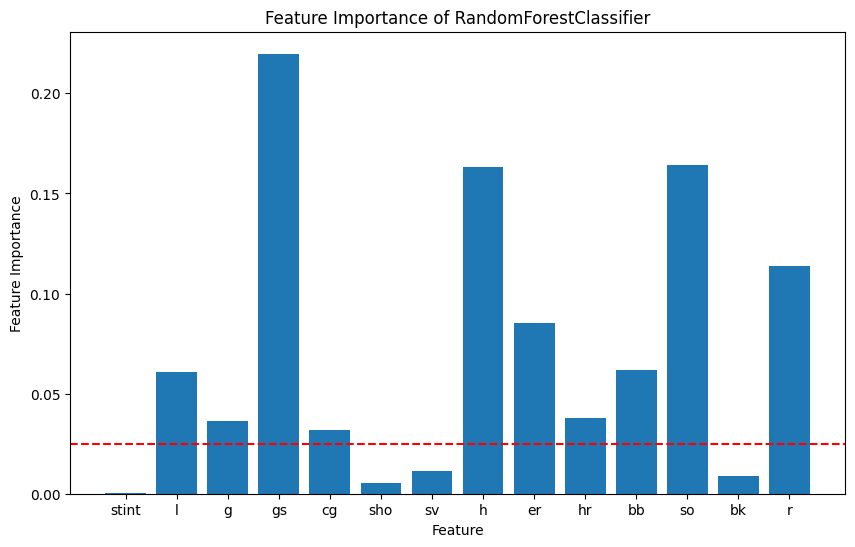

In [60]:
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, feature_importance, align='center')
plt.axhline(y = 0.025, linestyle = '--', label = 'Treshold', color = 'red')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance of RandomForestClassifier')
plt.show()

In [61]:
#importance가 0.025보다 작은 것은 제외
important_features = []
features = X_train.columns
for i, importance in enumerate(feature_importance):
  if importance >= 0.025:
    important_features.append(features[i])

In [62]:
important_features

['l', 'g', 'gs', 'cg', 'h', 'er', 'hr', 'bb', 'so', 'r']

In [63]:
#위의 feature만 골라서 새로 만들자
selected_feature_df = resampled[['l', 'g', 'gs', 'h', 'er', 'hr', 'bb', 'so', 'r']]

In [64]:
w = resampled['w']

In [65]:
selected_feature_df

,l,g,gs,h,er,hr,bb,so,r
0,13,40,21,193,79,13,66,74,83
1,12,31,31,228,98,27,49,78,110
2,11,35,35,227,108,20,74,114,120
3,10,59,0,87,40,7,40,79,43
4,8,35,14,132,53,8,43,75,59
...,...,...,...,...,...,...,...,...,...
25173,14,34,34,267,131,24,86,139,142
25174,7,32,32,210,88,21,69,105,100
25175,7,29,29,172,68,16,52,129,72
25176,5,71,0,90,35,6,43,97,43


In [77]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    selected_feature_df, w, test_size = 0.2, random_state = 123)

In [80]:
X_train2, X_validation2, y_train2, y_validation2 = train_test_split(
    X_train2, y_train2, test_size = 0.25, random_state = 123
)

In [81]:
rf2 = RandomForestClassifier()
rf2.fit(X_train2, y_train2)

RandomForestClassifier()

In [82]:
pred2 = rf2.predict(X_test2)
print('Accuracy: ',accuracy_score(pred2,y_test2))

Accuracy:  0.9559173947577443


In [83]:
rs_best_param = {
 'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': None,
 'criterion': 'entropy',
 'bootstrap': False
}
bo_best_param = {
    'bootstrap': 0.8463206514910923,
 'criterion': 0.27375556334171525,
 'max_depth': 20.14778519554769,
 'min_samples_leaf': 2.2439129157238815,
 'min_samples_split': 5.058707081634565,
 'n_estimators': 123.21565318421973
}

In [84]:
selected_param = {
    'min_samples_split' : 5,
    'min_samples_leaf' : 1,
    'max_depth' : 20,
    'bootstrap' : False,
    'criterion': (0,1),
    'n_estimators': (50,150)
}

In [85]:
def evaluate_model2(n_estimators,criterion):
    criterion = 'gini' if criterion < 0.5 else 'entropy'
    model = RandomForestClassifier(n_estimators = int(n_estimators),
                                   max_depth = 20,
                                   min_samples_split = 5,
                                   min_samples_leaf = 1,
                                   bootstrap = False,
                                   criterion = criterion)
    model.fit(X_train2, y_train2)
    return model.score(X_validation2, y_validation2)

In [86]:
BO = BayesianOptimization(f = evaluate_model2, pbounds = {
    'n_estimators': (50,150), 'criterion':(0,1)
    }, random_state = 123)
BO.maximize(init_points = 10, n_iter = 10)

|   iter    |  target   | criterion | n_esti... |
-------------------------------------------------
| 1         | 0.9555    | 0.6965    | 78.61     |
| 2         | 0.9563    | 0.2269    | 105.1     |
| 3         | 0.9583    | 0.7195    | 92.31     |
| 4         | 0.9581    | 0.9808    | 118.5     |
| 5         | 0.9581    | 0.4809    | 89.21     |
| 6         | 0.9583    | 0.3432    | 122.9     |
| 7         | 0.9565    | 0.4386    | 55.97     |
| 8         | 0.9577    | 0.398     | 123.8     |
| 9         | 0.9573    | 0.1825    | 67.55     |
| 10        | 0.9571    | 0.5316    | 103.2     |
| 11        | 0.9579    | 0.01274   | 120.8     |
| 12        | 0.9575    | 0.07683   | 95.06     |
| 13        | 0.9581    | 1.0       | 115.5     |
| 14        | 0.9573    | 0.05174   | 112.6     |
| 15        | 0.9589    | 0.9807    | 86.24     |
| 16        | 0.9583    | 0.0       | 84.66     |
| 17        | 0.9563    | 0.0       | 86.98     |
| 18        | 0.9573    | 0.9188    | 86.02     |


In [87]:
best_params2 = BO.max['params']
best_params2

{'criterion': 0.9806582588247188, 'n_estimators': 86.23541594850415}

In [88]:
best_model2 = RandomForestClassifier(
    n_estimators = 86,
    criterion = 'entropy',
     max_depth = 20,
     min_samples_split = 5,
     min_samples_leaf = 1,
     bootstrap = False,
)
best_model2.fit(X_train2,y_train2)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=20,
                       min_samples_split=5, n_estimators=86)

In [89]:
best_pred2 = best_model2.predict(X_test2)
print('Accuracy: ',accuracy_score(best_pred2, y_test2))

Accuracy:  0.9584988085782367
